In [6]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [26]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [31]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [3]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [4]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [7]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [8]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [9]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [10]:
# Look at 40 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [11]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [12]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [13]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [14]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [15]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None
    

In [16]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [17]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [18]:
def get_text_length(item):
    return len(item.test_prompt())

In [21]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(20)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888)]

In [22]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [23]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [24]:
# Look at features in a training item
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [27]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [28]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2642321862957332
rank: 5.197480233116737e-05
text_length: 0.0076093283513202605
is_top_electronics_brand: 198.14254283206898
Intercept: 182.18661987897428
Mean Squared Error: 33034.336771967995
R-squared Score: 0.09091571194865222


In [29]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

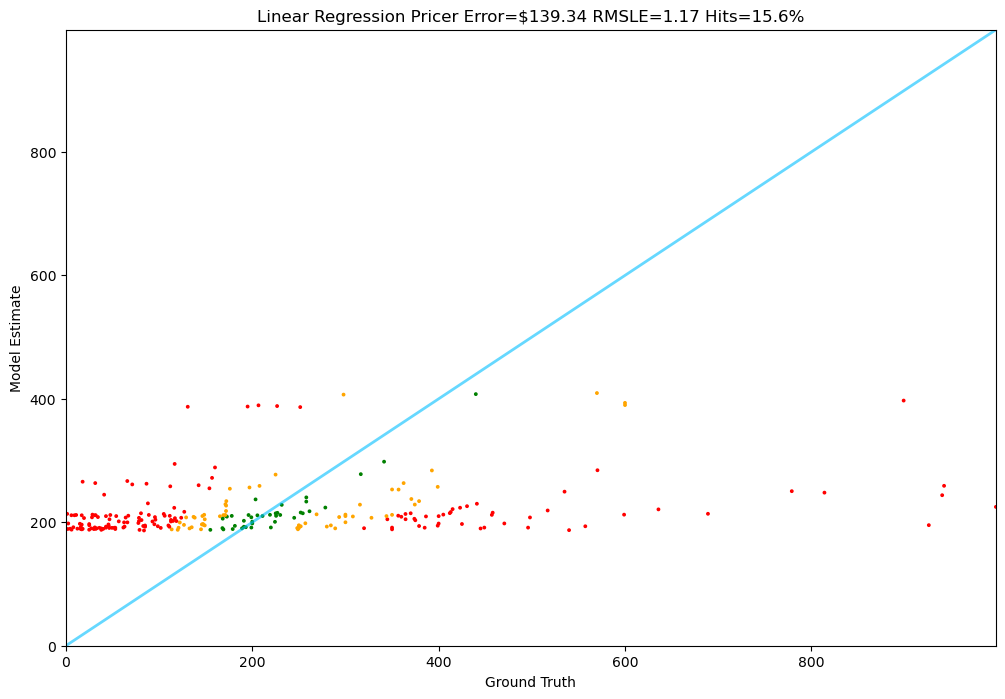

In [32]:
# test it

Tester.test(linear_regression_pricer)